In [1]:
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd
import re
import numpy.ma as ma

from copy import deepcopy
from corner import corner

from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth

from chainconsumer import ChainConsumer

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

WDIR = Path().cwd().parent
DDIR = Path("/dump/lukasw/data")


Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [38]:
def load_data(file):

    results = h5py.File(file, "r")
    name = str(Path(file).stem)

    try:
        __ = results['Observed']
        __ = results['Output']['Solutions']
    except KeyError:
        print(f"{file} does not have Observed or Solutions")
        results = None

    return name, results

def load_all_planet_data(path):
    path = Path(path)
    paths = Path(path).rglob("*.h5")
    paths = list(paths)

    results = [load_data(file) for file in paths]
    results = {k: v for k, v in results if v is not None}

    return results

In [46]:
pname = "WASP-76b"  # "WASP-76b"  # "HD209458b"
path = Path(f"/dump/lukasw/data/OBS/{pname}/")
results = load_all_planet_data(path)

In [47]:
def get_case_from_name(s):
    ls = s.split("_")
    instr = ls[1]
    chem = "NONE"
    fit_offset = ""
    if len(ls) == 3:
        chem = ls[2]
    elif len(ls) == 4:
        chem = ls[2]
        fit_offset = ls[3]
    else:
        raise NotImplementedError

    return instr, chem, fit_offset

def style_picker(instr, chem, fit_offset):
    if chem == "freeChem":
        ls = "solid"
    else:
        ls = "dashed"

    if instr == "G141":
        color = "blue"
    elif instr == "STIS":
        color = "purple"
    elif instr == "G141+STIS":
        if fit_offset == "fit-offset":
            color = "red"
        else:
            color = "green"
    elif instr == "G141+STIS+SPITZER":
        if fit_offset == "fit-offset":
            color = "gray"
        else:
            color = "yellow"
    else:
        raise NotImplementedError

    return {"c": color, "ls":ls}

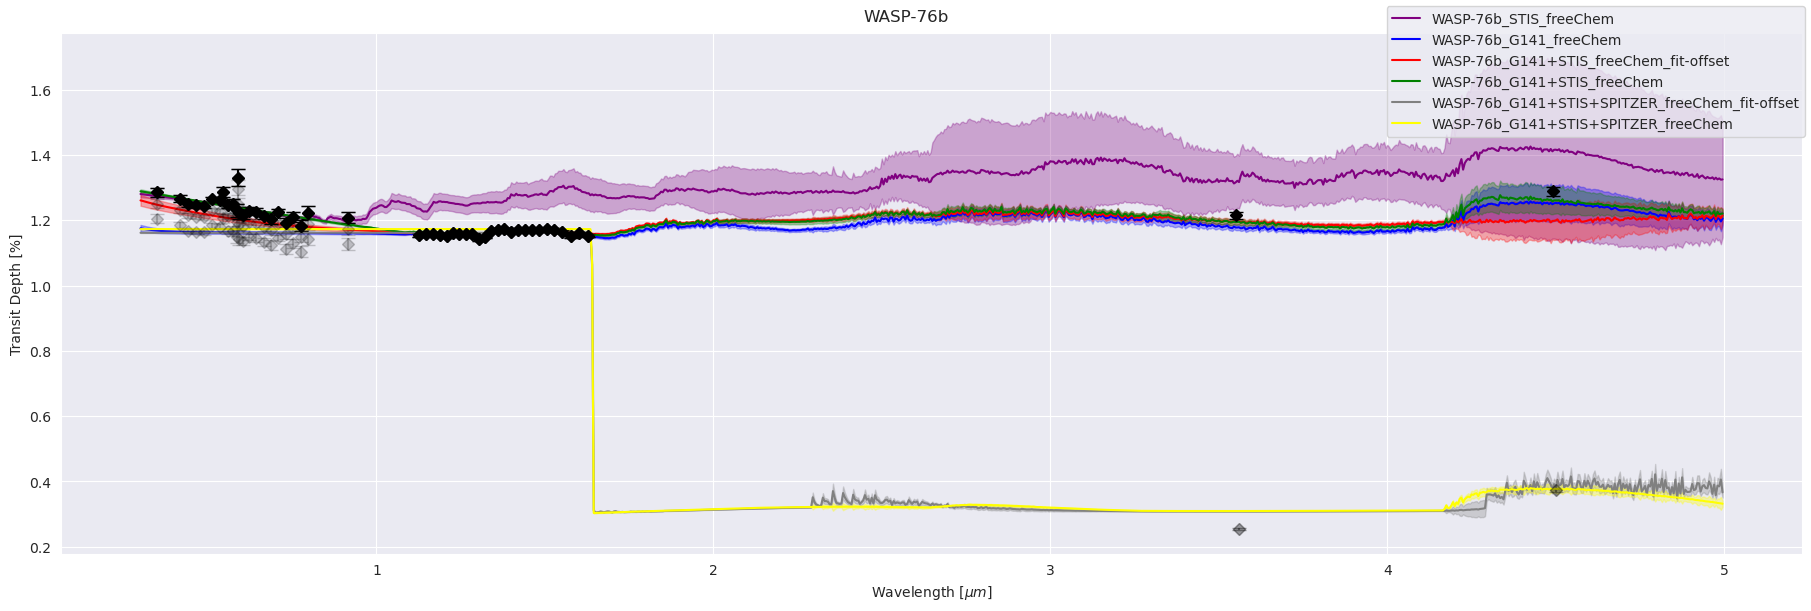

In [51]:
def bin_spectrum(low_res, high_res):
    transmission_spectra = high_res.sort_values(by='wavelength')
    low_res = low_res.sort_values(by='wavelength')
    low_res = low_res.reset_index(drop=True)

    binner = FluxBinner(low_res['wavelength'].values)

    _, binned_transit_depth, _, _ = binner.bindown(transmission_spectra['wavelength'].values,
                                                   transmission_spectra['depth'].values)

    return np.array(binned_transit_depth)


def plot_spectrum_into_ax(hdf5file, name, ax=None):
    ax = plt.gca()
    res = hdf5file

    instr, chem, fit_offset = get_case_from_name(name)

    style = style_picker(instr, chem, fit_offset)

    res_spec = res['Output']['Solutions']['solution0']['Spectra']
    factor = 1e2

    hr = pd.DataFrame(res_spec['native_wlgrid'][()], columns=['wavelength'])
    hr['depth'] = res_spec['native_spectrum'][()]

    bd = 0.005
    lr = pd.DataFrame(np.arange(0.3, 5, bd), columns=['wavelength'])
    lr['depth'] = bin_spectrum(lr.copy(), hr)

    hr_plus_std = hr.copy()
    hr_plus_std['depth'] = res_spec['native_spectrum'][()] + res_spec['native_std'][()]

    hr_minus_std = hr.copy()
    hr_minus_std['depth'] = res_spec['native_spectrum'][()] - res_spec['native_std'][()]

    lr['depth_m_std'] = bin_spectrum(lr.copy(), hr_minus_std)
    lr['depth_p_std'] = bin_spectrum(lr.copy(), hr_plus_std)

    try:
        if '_G141+STIS_freeChem' in name and not '_G141+STIS_freeChem_fit-offset' in name:
            ax.errorbar(res['Observed']['wlgrid'][()],
                        res['Observed']['spectrum'][()] * factor,
                        yerr=res['Observed']['errorbars'][()] * factor,
                        fmt='D', c='k', capsize=5)
        else:
            ax.errorbar(res['Observed']['wlgrid'][()],
                        res['Observed']['spectrum'][()] * factor,
                        yerr=res['Observed']['errorbars'][()] * factor,
                        fmt='D', c='k', capsize=5, alpha=0.2)
    except KeyError:
        pass
    ax.plot(lr['wavelength'], lr['depth'] * factor, c=style["c"], ls=style["ls"], label=f"{name}")
    ax.fill_between(lr['wavelength'], lr['depth_m_std'] * factor, lr['depth_p_std'] * factor, color=style["c"], alpha=0.3)
    # ax.set_xlim(0.28, 1.7)
    # ax.set_ylim(1.4, 1.55)
    # ax.set_xlim(0.28, 1.7)
    # ax.set_ylim(1.1, 1.4)
    ax.set_xlabel(r'Wavelength [$\mu m$]')
    ax.set_ylabel(r'Transit Depth [%]')
    # ax.set_xscale("symlog")
    return ax

fig, ax = plt.subplots(1, 1, num="spectrum_differences",
                       constrained_layout=True,
                       figsize=(18, 6))

for i, (name, file) in enumerate(results.items()):
    ax = plot_spectrum_into_ax(file, name)

ax.errorbar([3.55, 4.493],
            np.array([0.11026 ** 2, 0.11351**2]) * 1e2,
            yerr=np.array([(0.11026 + 0.00048) ** 2 - 0.11026 ** 2,
                           (0.11351 + 0.00056) ** 2 - 0.11351 ** 2]) * 1e2,
            fmt='D', c='k', capsize=5)

fig.legend()
fig.suptitle(pname)
fig.savefig(f"/dump/lukasw/data/OBS/{pname}/spectra.png", dpi=400)